# 0001 Sample Model

In [3]:
from common import setup_imports
from constants import *
import matplotlib.pyplot as plt
import seaborn as sns

import torch

setup_imports()
torch.cuda.empty_cache()

plt.style.use('ggplot')
sns.set_palette('Set2')

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Simple Model

### Data loading from GCS / Config yamml

In [4]:
from data import create_dataloader
from utils import load_config, validate_config
from utils.data_stream import DataStream

In [6]:
config = load_config(os.path.join(CONFIG_PATH, '001_sample_config.yaml'))
config = validate_config(config)

### Diversify Images

In [7]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((config['model']['input_size'], config['model']['input_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(p=0.5), # diversify perspective
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05), # diversify lighting condition
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)), # simulate noise
    transforms.RandomResizedCrop(size=416, scale=(0.8, 1.0)), # simulate altitude change
    transforms.RandomRotation(degrees=3) # diversify orientation
    
])

In [8]:
data_stream = DataStream(bucket_name=BUCKET_NAME)
train_loader, val_loader, test_loader = create_dataloader(
    config=config,
    data_stream=data_stream,
    transform=transform
)

/home/automatedtomato/github.com/automatedtomato/sar-yolo/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/automatedtomato/github.com/automatedtomato/sar-yolo/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Train Samples: 6129, Val Samples: 2043, Test Samples: 2043


In [10]:
from models.yolov3 import YOLOv3

model_001 = YOLOv3(n_classes=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_001 = model_001.to(device)

cuda


In [12]:
from models.train_val.train_val import train_model

model_001, train_history, val_history = train_model(
    model=model_001,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    device=device
)

Training model...
  Number of epochs: 30
  Device: cuda
  Patience: 5
  Save path: 002_sample_best_model.pt



  Epoch: 1/30 - Batch: 0/767 - Loss: 4568.7964
      (Coord: 108.5681, Obj: 2553.6973, NoObj: 1895.3165, Class: 11.2144)
  Epoch: 1/30 - Batch: 20/767 - Loss: 4099.9902
      (Coord: 159.1492, Obj: 3101.8879, NoObj: 837.2234, Class: 1.7297)
  Epoch: 1/30 - Batch: 40/767 - Loss: 3573.1792
      (Coord: 106.5212, Obj: 2702.9028, NoObj: 763.1082, Class: 0.6470)
  Epoch: 1/30 - Batch: 60/767 - Loss: 3932.3447
      (Coord: 97.3821, Obj: 3058.4685, NoObj: 776.0846, Class: 0.4097)
  Epoch: 1/30 - Batch: 80/767 - Loss: 4107.0791
      (Coord: 155.3515, Obj: 3205.3889, NoObj: 745.9846, Class: 0.3541)
  Epoch: 1/30 - Batch: 100/767 - Loss: 4178.1465
      (Coord: 185.9699, Obj: 3273.8984, NoObj: 718.0570, Class: 0.2211)
  Epoch: 1/30 - Batch: 120/767 - Loss: 3949.0859
      (Coord: 77.3664, Obj: 2976.3438, NoObj: 895.0410, Class: 0.3346)
  Epoch: 1/30 - Batch: 140/767 - Loss: 4907.1689
      (Coord: 581.3108, Obj: 3466.1357, NoObj: 859.4086, Class: 0.3140)
  Epoch: 1/30 - Batch: 160/767 - Loss:

In [ ]:
import pandas as pd
metrics = {
    'model': [],
    'epochs': [],
    'lr' : [],
    'weight_decay': [],
    'batch_size': [],
    'train_loss': [],
    'val_loss': [],
    'mAP': [],
    
}

Figure saved at figures/001_learning_curve.png


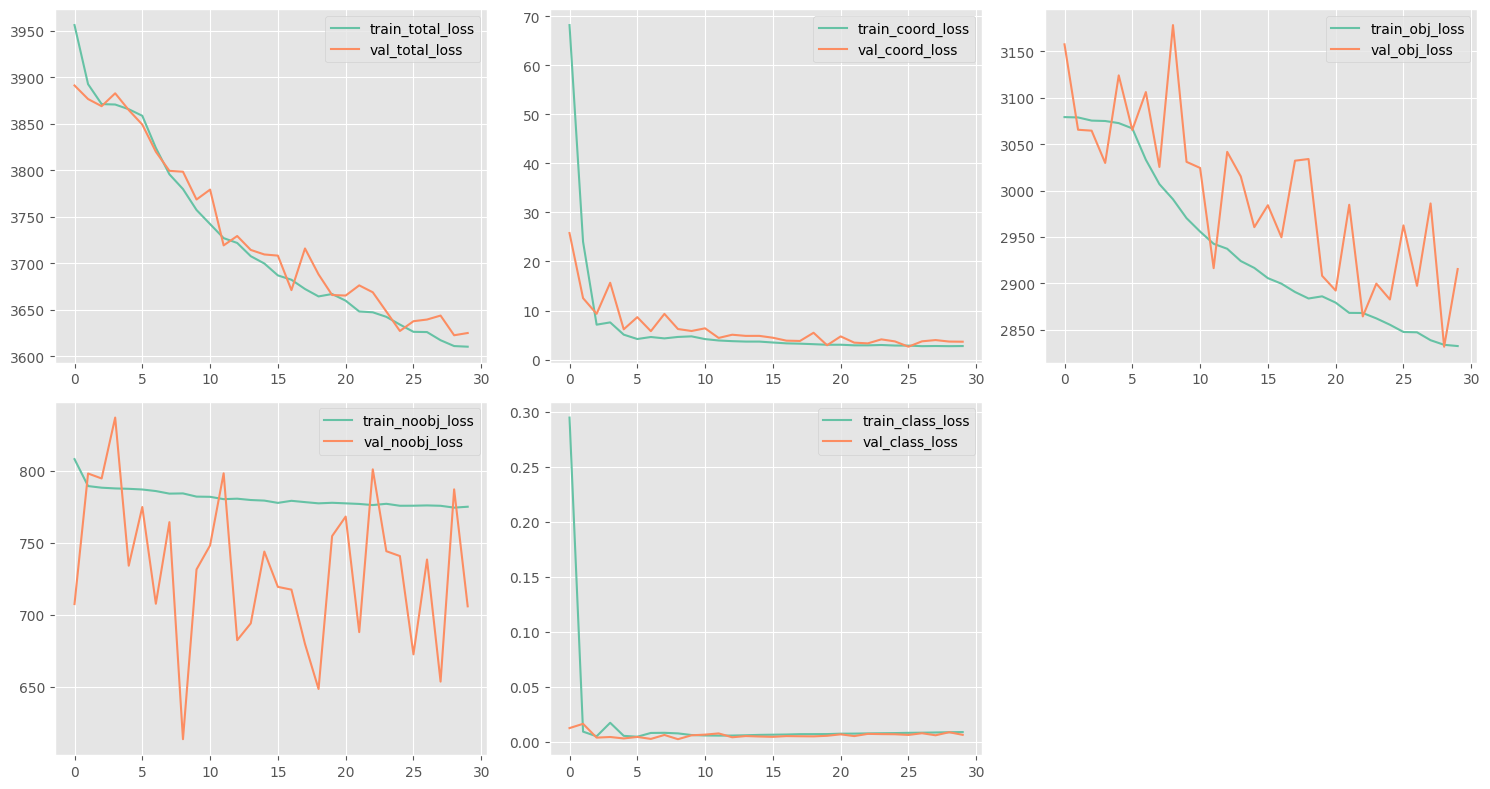

In [15]:
from models.train_val import learning_curve

learning_curve(train_history, val_history, save_path='figures/001_learning_curve.png')